### Configuración Inicial

Importamos todos los módulos que se van a utilizar y definimos funciones generales que se usan en distintas partes del trabajo.

In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dataset = pd.read_csv("properati_argentina_2021.csv")
sns.set()

SEMILLA = 0
TEST_SIZE = 0.2


def obtener_frecuencia_relativa(series):
    frecuencia_absoluta = series.value_counts()
    frecuencia_relativa = frecuencia_absoluta / frecuencia_absoluta.sum()
    return frecuencia_relativa


def separate_date(dataset, column_name):
    dataset[f"{column_name}_year"] = dataset[column_name].str[:4].astype(int)
    dataset[f"{column_name}_month"] = dataset[column_name].str[5:7].astype(int)
    dataset[f"{column_name}_day"] = dataset[column_name].str[8:10].astype(int)
    dataset.drop([column_name], axis=1, inplace=True)



# 1. Análisis Exploratorio y Preprocesamiento de Datos


## Separación Train-Test

En primer lugar separamos el dataset con el que se va a trabajar en dos: el 80% se utilizará para entrenar a los modelos y el 20% para testear que los modelos estén funcionando como se espera.

Se realiza la separación antes de comenzar a trabajar los datos para que durante la etapa de entrenamiento no haya conocimiento sobre los datos que luego se usarán para testear y así pueda predecir de forma adecuada.

In [2]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

print("Proporción - Train: {:.2f}".format(dataset_train.shape[0] / dataset.shape[0]))
print("Proporción - Test: {:.2f}".format(dataset_test.shape[0] / dataset.shape[0]))

Proporción - Train: 0.80
Proporción - Test: 0.20


## Filtrado del set de Training

Damos un primer vistazo al dataset, para observar las columnas y sus valores.

In [3]:
dataset_train.head(5)

id  start_date    end_date  created_on  \
19012   f19OtftrEdr1twkOwQdmIw==  2021-01-27  2021-07-01  2021-01-27   
418309  Ak3A3BAUvl8vjWRpGdMSqg==  2021-10-14  2021-11-03  2021-10-14   
157888  K8U3zUGHru2nNfFhsz8ckA==  2021-05-26  2021-06-27  2021-05-26   
405630  ZauA5QYZtApfKQkF5gIu+A==  2021-01-07  2021-09-03  2021-01-07   
147192  Cvf0fa9tdZflz/jma3g2Kw==  2021-08-19  2021-10-14  2021-08-19   

          latitud   longitud                  place_l2  place_l3  place_l4  \
19012         NaN        NaN  Bs.As. G.B.A. Zona Norte       NaN       NaN   
418309 -34.400856 -58.649901  Bs.As. G.B.A. Zona Norte     Tigre  Nordelta   
157888 -32.891939 -68.854564                   Mendoza   Mendoza       NaN   
405630 -34.895556 -57.977944    Bs.As. G.B.A. Zona Sur  La Plata    Tolosa   
147192 -34.900083 -56.171641                Montevideo       NaN       NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
19012       NaN       NaN     Venta          Casa             7.0   
418309      NaN       NaN     Venta  Departamento             3.0   
157888      NaN       NaN  Alquiler  Departamento             2.0   
405630      NaN       NaN     Venta          Casa             5.0   
147192      NaN       NaN  Alquiler  Departamento             NaN   

        property_bedrooms  property_surface_total  property_surface_covered  \
19012                 5.0                   269.0                     269.0   
418309                2.0                    95.0                      88.0   
157888                1.0                   120.0                      60.0   
405630                3.0                    85.0                      85.0   
147192                1.0                    55.0                      45.0   

        property_price property_currency  \
19012         380000.0               USD   
418309        170000.0               USD   
157888         28500.0               ARS   
405630        110000.0               USD   
147192         19900.0               UYU   

                                           property_title  
19012                                       Casa - Zarate  
418309  DEPARTAMENTO VENTA ANTARES NORDELTA 3 AMBIENTE...  
157888  Alquiler DEPARTAMENTO  en Ciudad, a mts Aristides  
405630  Duplex venta 3 dormitorios 2 baños 1 cochera 8...  
147192   Apartamento de 1 dormitorio en ALQUILER - Cordón

Definimos un diccionario de filtros que vamos a utilizar para filtrar nuestro dataset, y filtramos las columnas que no nos interesan; antes de filtrarlas, normalizamos sus valores por si hay alguna discrepancia.

In [4]:
filtro_tipo_propiedad = ["casa", "ph", "departamento"]
filtro_operacion = ["venta"]
filtro_ubicacion = ["capital federal"]
filtro_moneda = ["usd"]

filtros = {
    "property_type": filtro_tipo_propiedad,
    "operation": filtro_operacion,
    "place_l2": filtro_ubicacion,
    "property_currency": filtro_moneda,
}

for columna in filtros:
    dataset_train[columna] = dataset_train[columna].str.lower()

for columna_a_filtrar, filtro in filtros.items():
    dataset_train = dataset_train[dataset_train[columna_a_filtrar].isin(filtro)]

dataset_train.shape


(75488, 20)

Observamos la proporción de datos NULL en las columnas del dataset.

In [5]:
filas_totales = dataset_train.shape[0]
proporcion_null = dataset_train.isna().sum() / filas_totales * 100
proporcion_null.sort_values(ascending=False, inplace=True)
proporcion_null


place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.131836
property_bedrooms            11.532959
property_surface_total        5.129292
latitud                       3.972817
longitud                      3.972817
property_surface_covered      3.572753
property_rooms                1.092889
place_l3                      0.435831
property_currency             0.000000
property_price                0.000000
id                            0.000000
property_type                 0.000000
operation                     0.000000
start_date                    0.000000
place_l2                      0.000000
created_on                    0.000000
end_date                      0.000000
property_title                0.000000
dtype: float64

Observamos que las columnas `place_l5` y `place_l6` contienen `NaN` en todas sus filas y `place_4` contiene `NaN` en el 96% de sus filas. Por estas razones, eliminamos las columnas.

Las columnas `id` y `property_title` no nos sirven para predecir nada, ya que son valores arbitrarios que no aportan al análisis. Por lo que también las eliminamos.

Luego, debido al filtrado realizado previamente, las columnas `property_currency`, `place_l2`, `operation` contienen un solo valor posible, por lo que también las eliminamos ya que no aportan información extra al análisis.


In [6]:
columnas_eliminar = [
    "property_title",
    "id",
    "place_l4",
    "place_l5",
    "place_l6",
    "property_currency",
    "operation",
    "place_l2",
]
dataset_train.drop(columnas_eliminar, axis=1, inplace=True)


Como `place_l3` no es un nombre muy significativo, lo renombramos a `barrio`. Y estandarizamos la columna, seteando los datos invalidos a None

In [7]:
dataset_train = dataset_train.rename(columns={"place_l3": "barrio"})
 
dataset_train["barrio"] = dataset_train["barrio"].apply(lambda barrio: barrio if type(barrio) == str else None)

Convertimos las fechas a un mejor formato para poder realizar el análisis de forma más cómoda.

In [8]:

dataset_train["start_date"] = pd.to_datetime(
    dataset_train["start_date"], errors="coerce"
)
dataset_train["end_date"] = pd.to_datetime(dataset_train["end_date"], errors="coerce")
dataset_train["created_on"] = pd.to_datetime(
    dataset_train["created_on"], errors="coerce"
)

## Análisis Exploratorio

### Análisis Inicial


Observamos la estructura general del dataset.


In [9]:
dataset_train.shape

(75488, 12)

In [10]:
dataset_train.dtypes

start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
barrio                              object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
property_price                     float64
dtype: object

In [11]:
dataset_train.head(5)

start_date   end_date created_on    latitud   longitud        barrio  \
83944  2021-02-05 2021-03-05 2021-02-05 -34.554271 -58.457668      Belgrano   
195386 2021-08-21 2021-08-24 2021-08-21 -34.613544 -58.368072     Monserrat   
293157 2021-02-23 2021-03-01 2021-02-23 -34.571020 -58.433125       Palermo   
384577 2021-09-06 2021-10-23 2021-09-06 -34.597384 -58.405139  Barrio Norte   
450142 2021-12-16 2022-02-09 2021-12-16 -34.591646 -58.418064       Palermo   

       property_type  property_rooms  property_bedrooms  \
83944   departamento             2.0                1.0   
195386  departamento             3.0                2.0   
293157  departamento             2.0                1.0   
384577  departamento             4.0                3.0   
450142  departamento             1.0                NaN   

        property_surface_total  property_surface_covered  property_price  
83944                     59.0                      59.0        178000.0  
195386                    71.0                      71.0        129000.0  
293157                    79.0                      59.0        249000.0  
384577                    91.0                      85.0        165000.0  
450142                    37.0                      32.0        105000.0

Separamos el dataset en variables cualitativas, cuantitativas, y temporales.

In [12]:
columnas_cuantitativas = [
    "latitud",
    "longitud",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered",
    "property_price",
]
variables_cuantitativas = dataset_train[columnas_cuantitativas]
variables_cuantitativas.head()

latitud   longitud  property_rooms  property_bedrooms  \
83944  -34.554271 -58.457668             2.0                1.0   
195386 -34.613544 -58.368072             3.0                2.0   
293157 -34.571020 -58.433125             2.0                1.0   
384577 -34.597384 -58.405139             4.0                3.0   
450142 -34.591646 -58.418064             1.0                NaN   

        property_surface_total  property_surface_covered  property_price  
83944                     59.0                      59.0        178000.0  
195386                    71.0                      71.0        129000.0  
293157                    79.0                      59.0        249000.0  
384577                    91.0                      85.0        165000.0  
450142                    37.0                      32.0        105000.0

In [13]:
columnas_temporales = [
    "start_date",
    "end_date",
    "created_on",
]
variables_temporales = dataset_train[columnas_temporales]
variables_temporales.head()

start_date   end_date created_on
83944  2021-02-05 2021-03-05 2021-02-05
195386 2021-08-21 2021-08-24 2021-08-21
293157 2021-02-23 2021-03-01 2021-02-23
384577 2021-09-06 2021-10-23 2021-09-06
450142 2021-12-16 2022-02-09 2021-12-16

In [14]:
columnas_cualitativas = ["barrio", "property_type"]
variables_cualitativas = dataset_train[columnas_cualitativas]
variables_cualitativas.head()

barrio property_type
83944       Belgrano  departamento
195386     Monserrat  departamento
293157       Palermo  departamento
384577  Barrio Norte  departamento
450142       Palermo  departamento

### Variables Cuantitativas

En primer lugar generamos estadísticas descriptivas para las columnas cuantitativas (medidas de resumen).

In [15]:
variables_cuantitativas.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  72489.000000  72489.000000    74663.000000       66782.000000   
mean     -34.591551    -58.448800        2.824130           2.014255   
std        0.181312      0.282378        1.419647           1.126561   
min      -53.788624    -71.438923        1.000000           1.000000   
25%      -34.616027    -58.466524        2.000000           1.000000   
50%      -34.595870    -58.438917        3.000000           2.000000   
75%      -34.577492    -58.408846        4.000000           3.000000   
max      -24.219827    -54.133330       40.000000          70.000000   

       property_surface_total  property_surface_covered  property_price  
count            71616.000000              72791.000000    7.548800e+04  
mean               111.177823                 89.711214    2.263084e+05  
std               1069.452095               1101.207263    3.213432e+05  
min                 10.000000                  1.000000    5.000000e+03  
25%                 45.000000                 40.000000    9.500000e+04  
50%                 65.000000                 58.000000    1.440000e+05  
75%                105.000000                 89.000000    2.380000e+05  
max             137000.000000             217000.000000    2.140000e+07

Luego, graficamos un mapa de correlaciones.

Text(0.5, 1.0, 'Correlación entre variables cuantitativas')

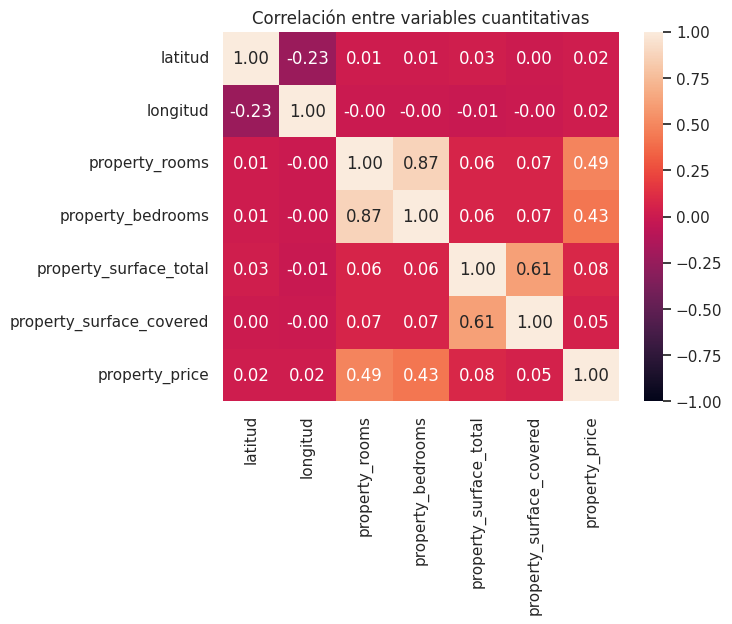

In [16]:
matriz_correlaciones = variables_cuantitativas.corr()
sns.heatmap(data=matriz_correlaciones, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlación entre variables cuantitativas")

Observamos que las variables más relacionadas son:
 - `property_rooms` con `property_bedrooms`
 - `property_surface_covered` con `property_surface_total`
 
 y en menor medida:
 - `property_price` con `property_rooms` y `property_bedrooms`


Realizamos graficos para observar estas relaciones de forma más clara.

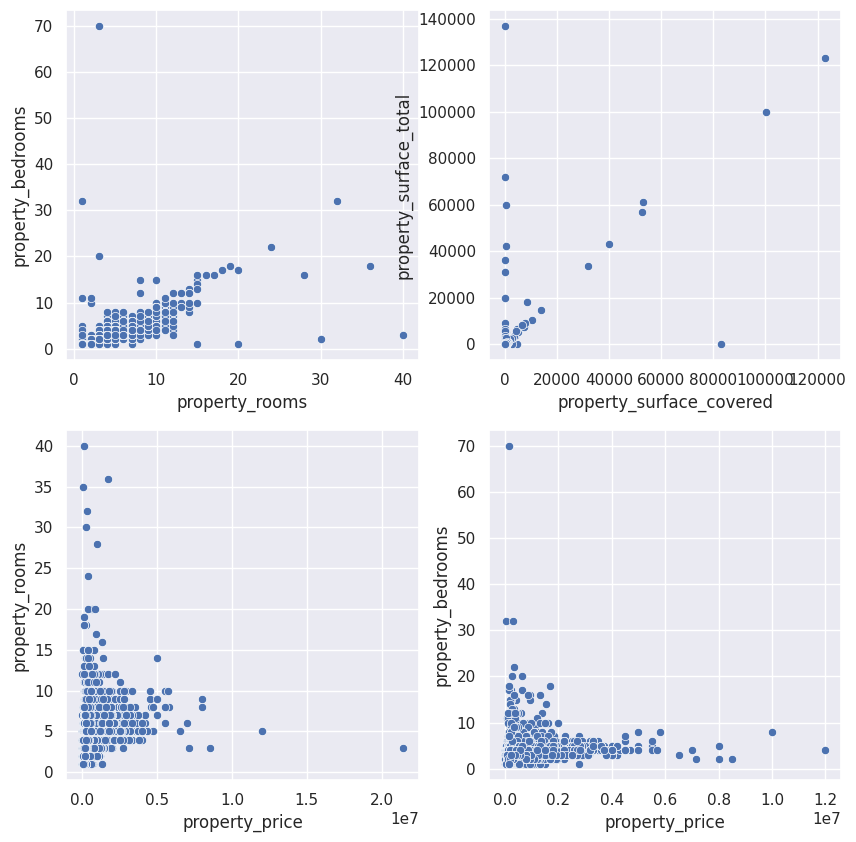

In [17]:
figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)

correlaciones = (
    ("property_rooms", "property_bedrooms"),
    ("property_surface_covered", "property_surface_total"),
    ("property_price", "property_rooms"),
    ("property_price", "property_bedrooms"),
)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=dataset_train, x=correlacion[0], y=correlacion[1])


Observamos que hay cierta relación lineal, pero es afectada por el alto numero de valores atípicos. Si se los elimina de forma "burda" se puede ver que el gráfico cambia drásticamente, por lo que luego será necesario hacer un tratamiento de esos valores.

Graficamos con un _alpha_ para observar mejor la distribución.

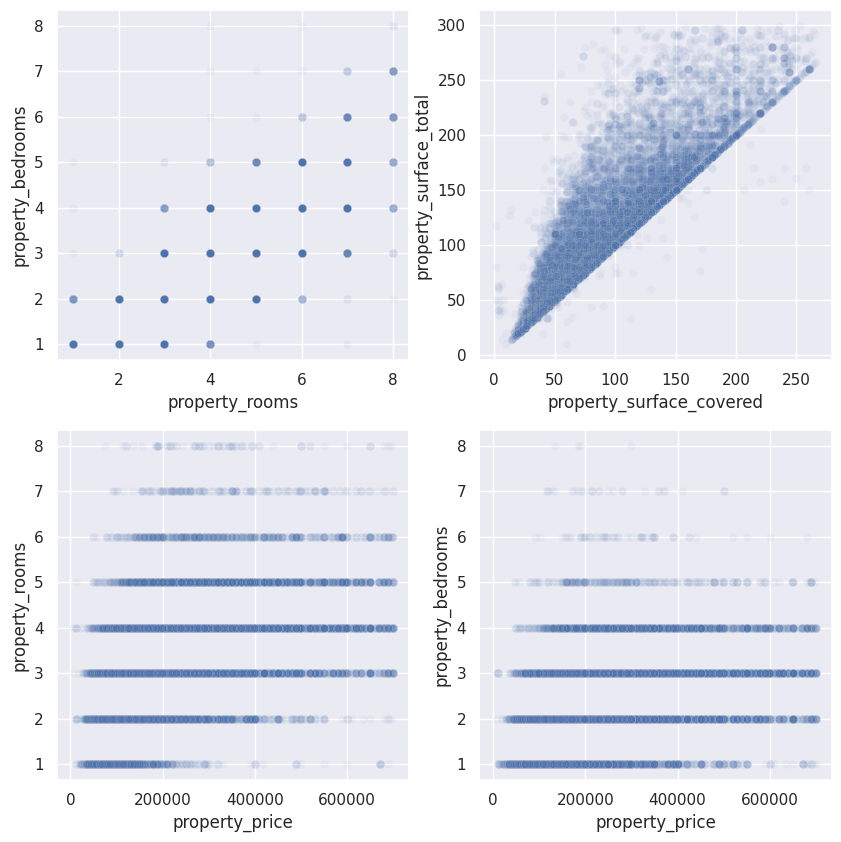

In [18]:
columnas = (
    "property_surface_covered",
    "property_surface_total",
    "property_rooms",
    "property_bedrooms",
    "property_price",
)
sin_atipicos = dataset_train.copy()
for columna in columnas:
    sin_atipicos = sin_atipicos[
        sin_atipicos[columna] < sin_atipicos[columna].quantile(0.75) * 3
    ]


figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=sin_atipicos, x=correlacion[0], y=correlacion[1], alpha=0.05)


### Variables Cualitativas

Analizamos la cantidad de valores posibles de cada variable.


In [19]:
variables_cualitativas.nunique()

barrio           57
property_type     3
dtype: int64

Graficamos la distribución de los barrios y del tipo de propiedad.

[Text(0.5, 1.0, 'Distribución del tipo de propiedad'),
 Text(0.5, 0, 'tipo de propiedad'),
 Text(0, 0.5, 'frecuencia')]

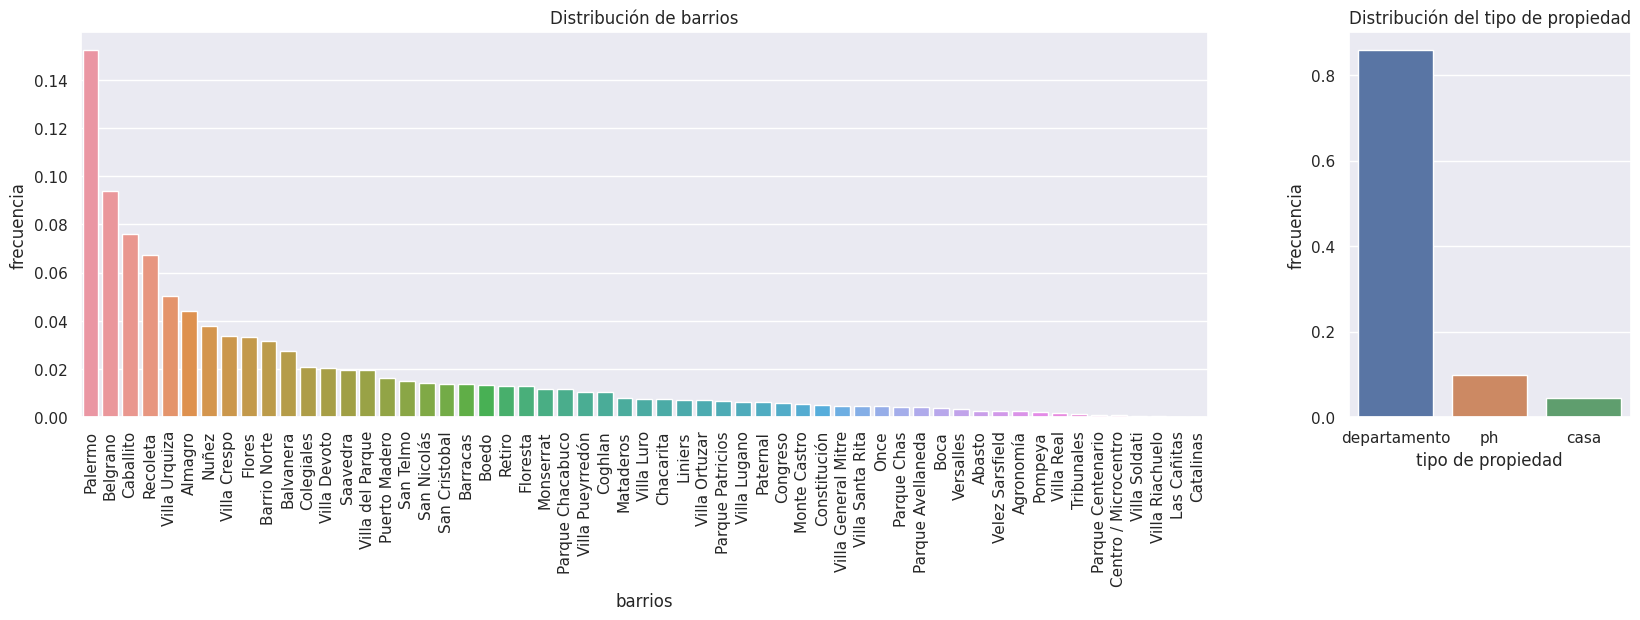

In [20]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(20, 5), gridspec_kw={"width_ratios": [4, 1]}
)

frecuencia_relativa = obtener_frecuencia_relativa(variables_cualitativas["barrio"])
ax = sns.barplot(ax=axes[0], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(title="Distribución de barrios", xlabel="barrios", ylabel="frecuencia")
ax.tick_params("x", labelrotation=90)

frecuencia_relativa = obtener_frecuencia_relativa(
    variables_cualitativas["property_type"]
)
ax = sns.barplot(ax=axes[1], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución del tipo de propiedad",
    xlabel="tipo de propiedad",
    ylabel="frecuencia",
)


### Variables Temporales

Graficamos la distribución de las variables temporales.


[Text(0.5, 1.0, 'Distribución de fecha de creación')]

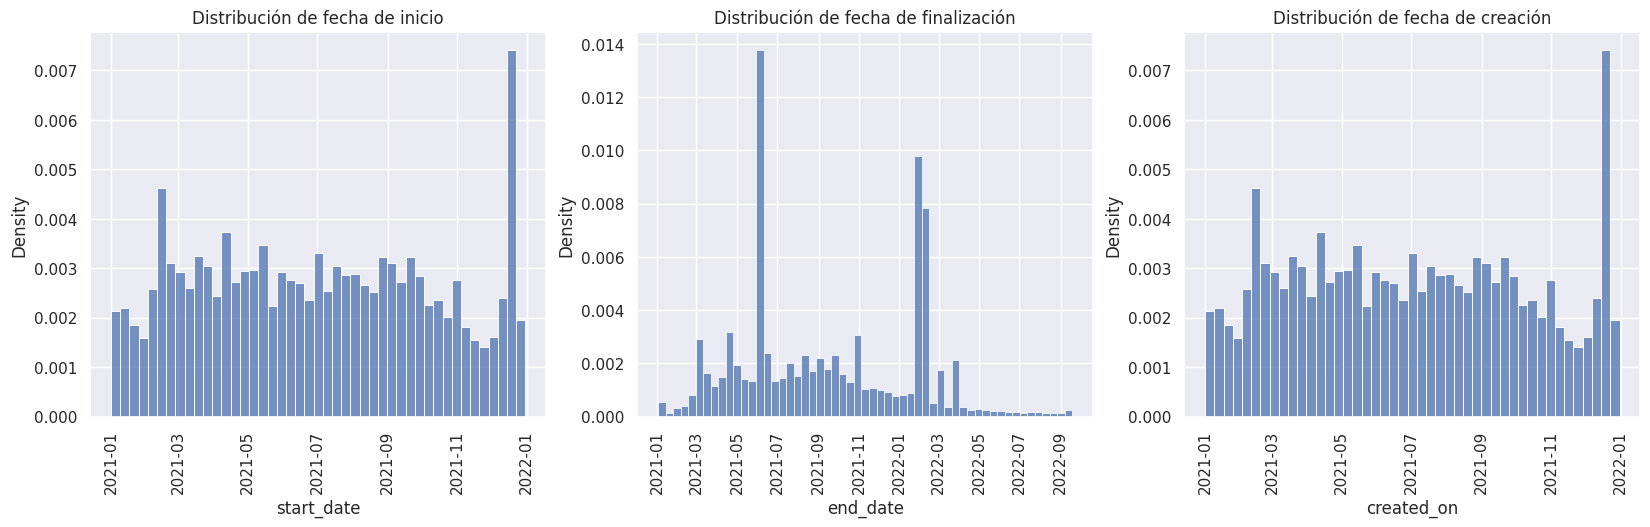

In [21]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for ax in axes:
    ax.tick_params("x", labelrotation=90)

sns.histplot(ax=axes[0], data=variables_temporales, x="start_date", stat="density").set(
    title="Distribución de fecha de inicio"
)
sns.histplot(ax=axes[1], data=variables_temporales, x="end_date", stat="density").set(
    title="Distribución de fecha de finalización"
)
sns.histplot(ax=axes[2], data=variables_temporales, x="created_on", stat="density").set(
    title="Distribución de fecha de creación"
)


Observamos que la variable `created_on` tiene distribución prácticamente idéntica a `start_date`, por lo que se podría eliminar sin perder información ((reduccion de dimensionalidad))

 ## Análisis de Valores Atípicos Univariados

Primero realizamos un **BOXPLOT** de las variables cuantitativas para observar de forma rápida la distribución de _outliers univariados_.

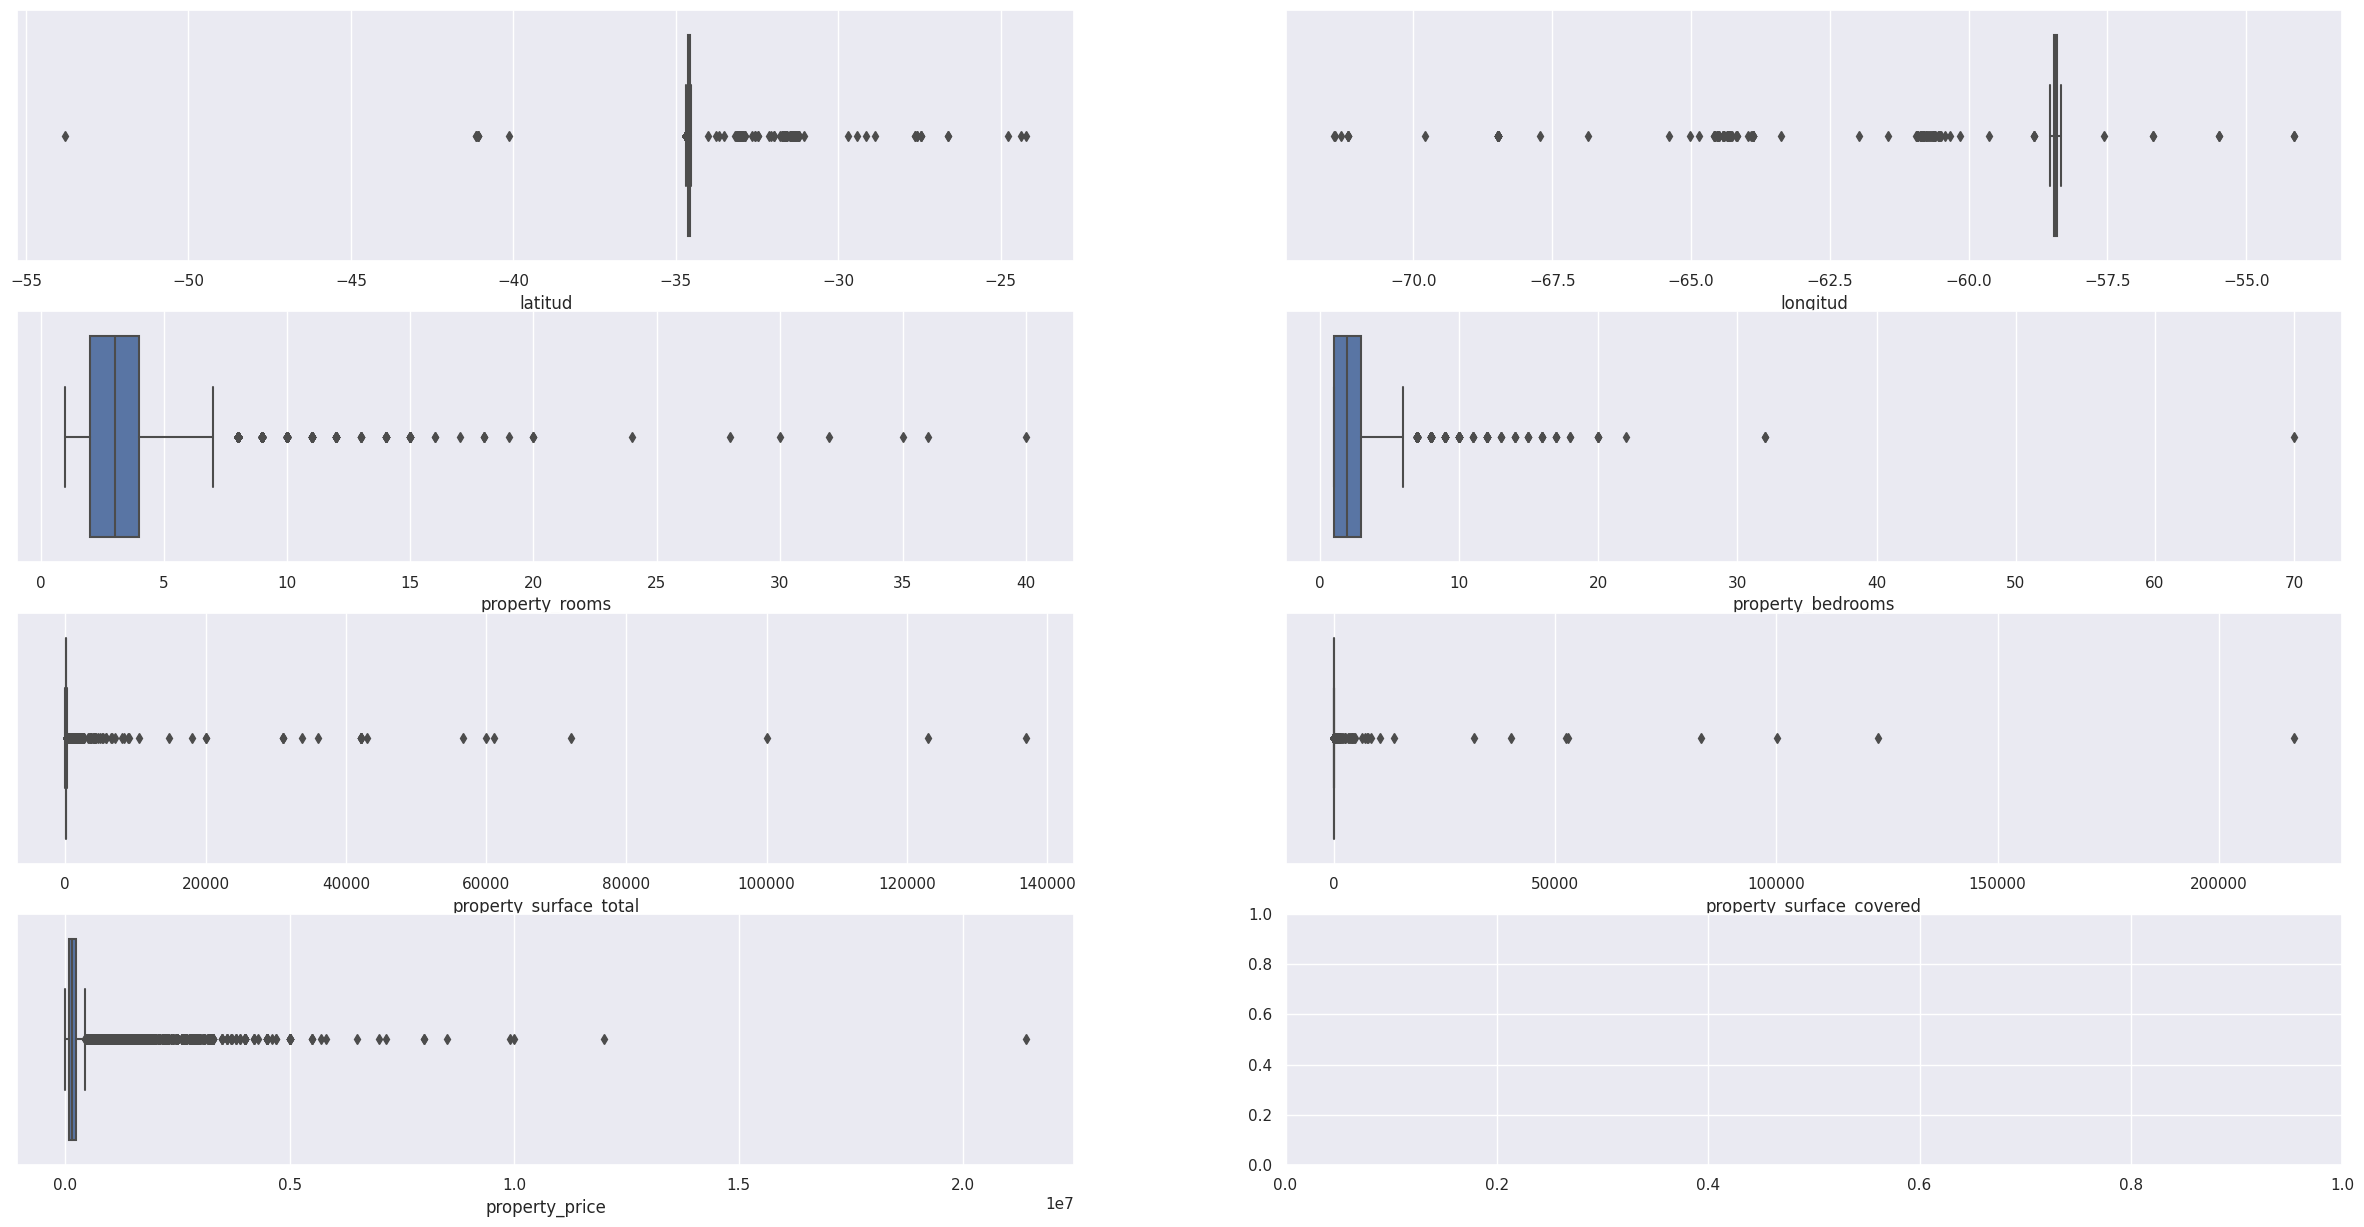

In [22]:
figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico=sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)
    

Observamos que quedan muchos valores que se salen del rango intercuartil, por lo que podemos eliminar aquellos que quedan fuera de: rango intercuartil * 3; es decir, los outliers severos.

In [23]:
for columna in variables_cuantitativas.columns:

    columna_q1 = dataset_train[columna].quantile(0.25)
    columna_q3 = dataset_train[columna].quantile(0.75)    
    iqr = columna_q3 - columna_q1

    lim_superior = columna_q3 + 3*iqr
    lim_inferior = columna_q1 - 3*iqr

    filtro_columna = (dataset_train[columna] >= lim_superior) | (dataset_train[columna] <= lim_inferior)
    indices = dataset_train[filtro_columna].index
    dataset_train.drop(index=indices, inplace=True)

Al realizar nuevamente el **BOXPLOT**, observamos que la distribuciones son mucho más uniformes

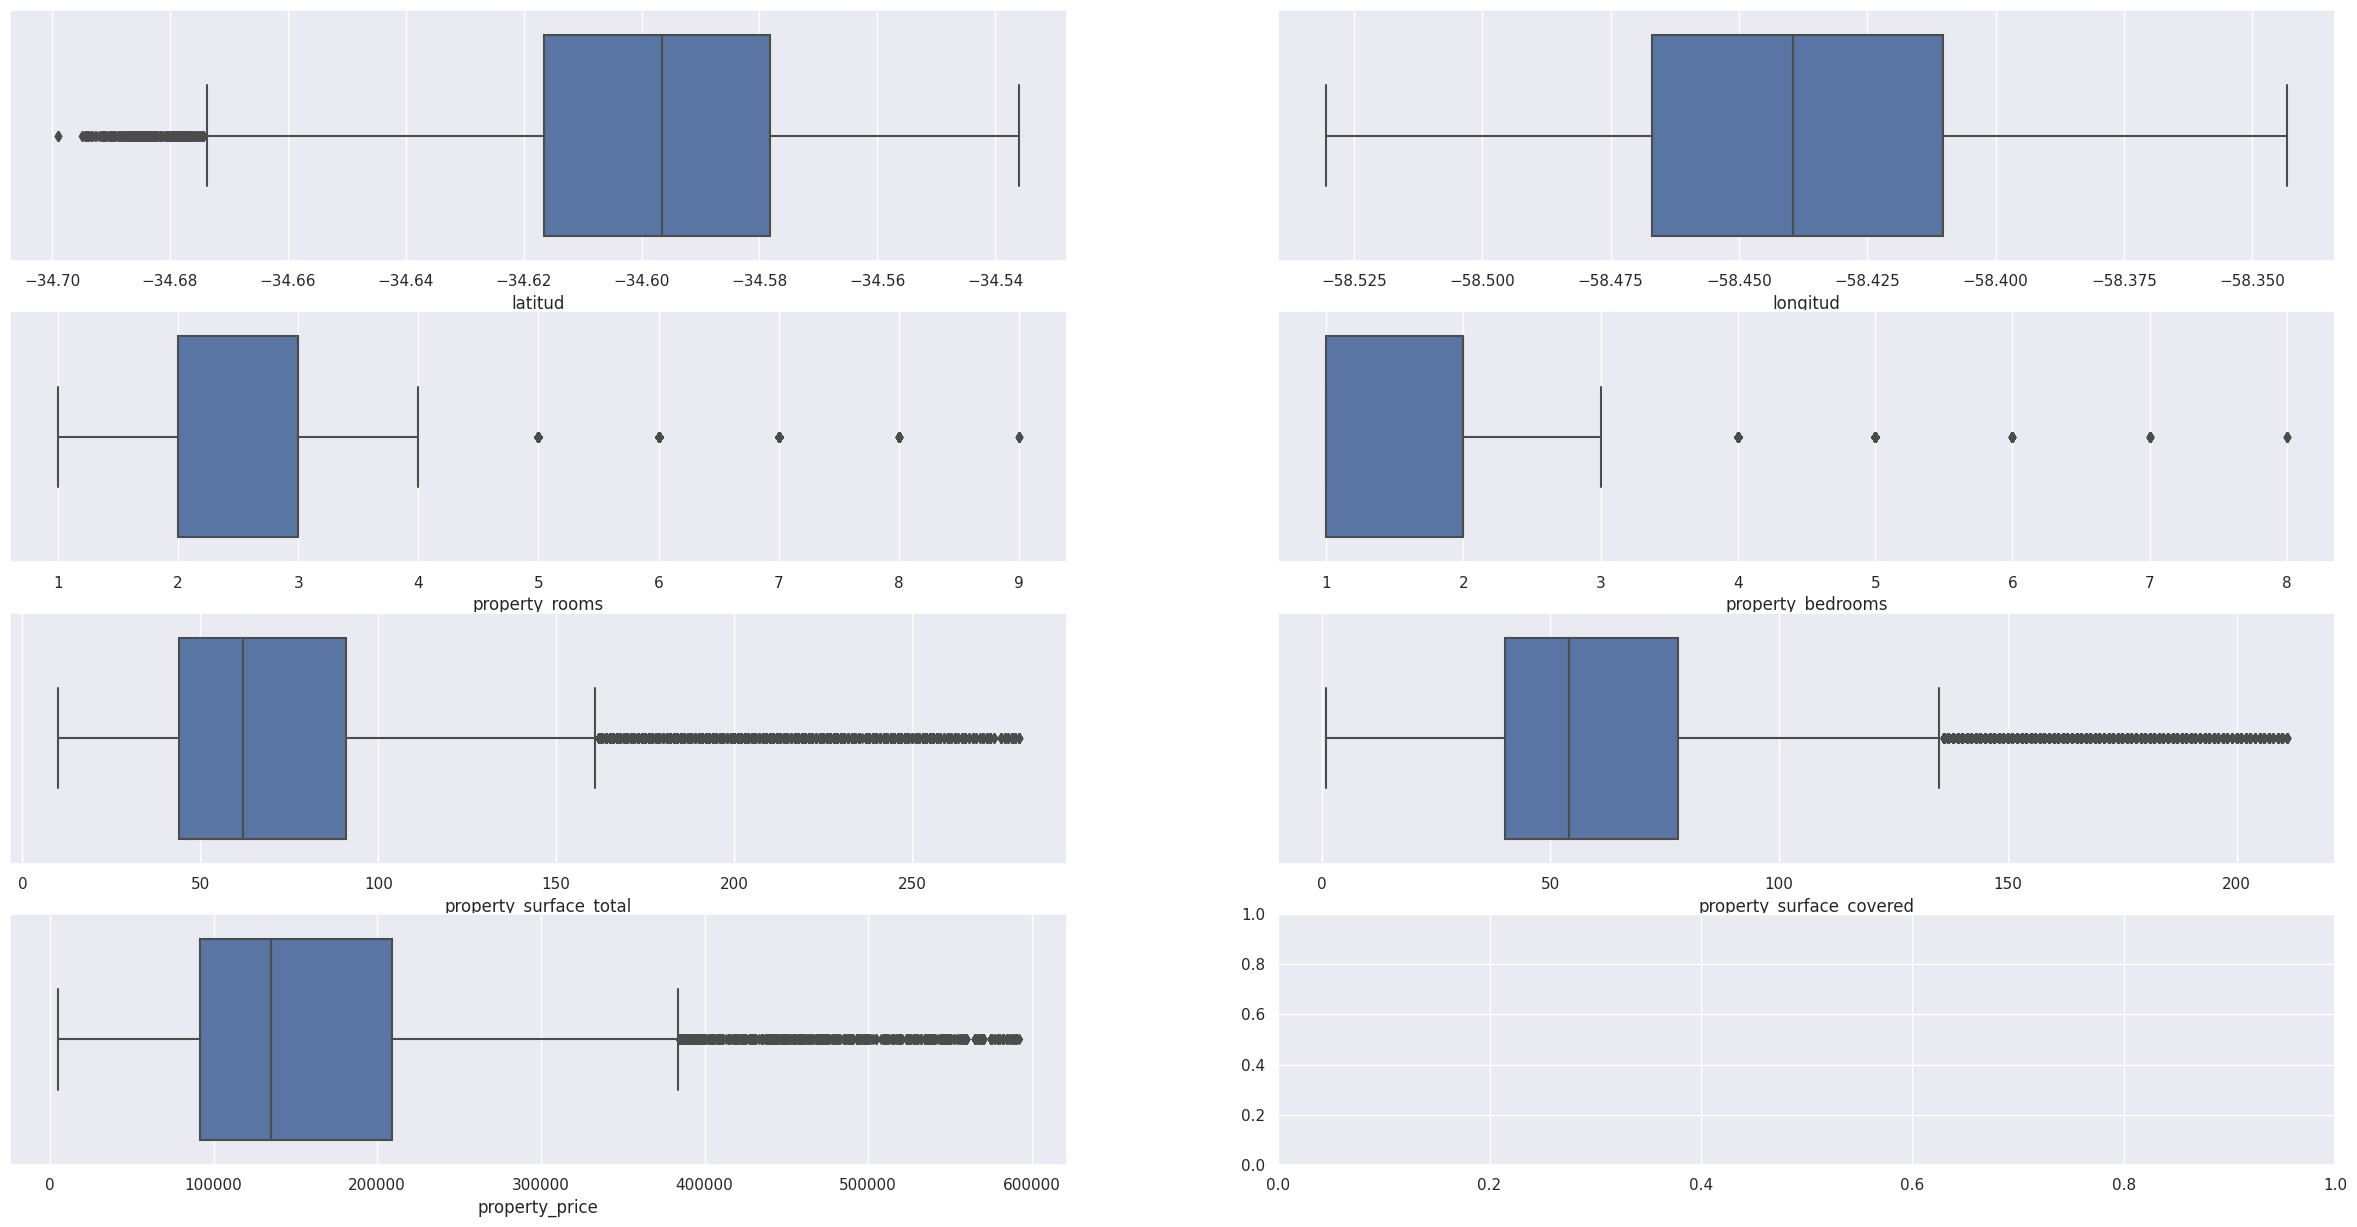

In [24]:
variables_cuantitativas = dataset_train[columnas_cuantitativas]

figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico = sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)


## Análisis de datos faltantes


Graficamos la distribución de datos nulos.

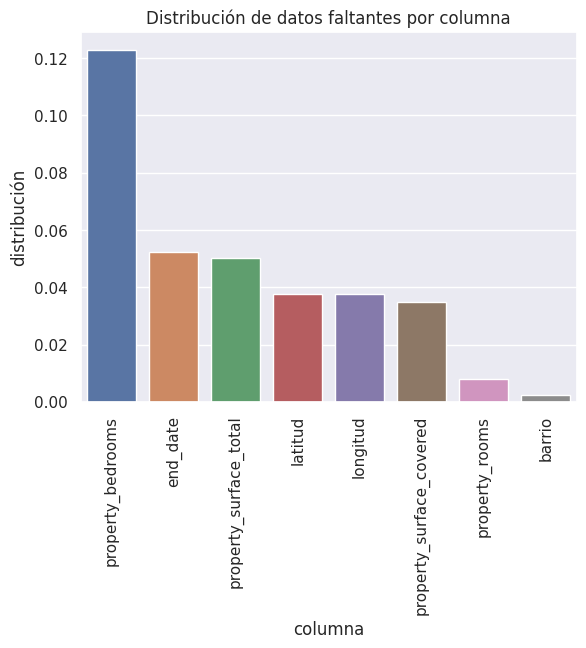

In [25]:
cantidad_de_datos_nulos_por_columna = dataset_train.isna().sum()
frecuencia_relativa = cantidad_de_datos_nulos_por_columna / dataset_train.shape[0]
frecuencia_relativa = frecuencia_relativa[frecuencia_relativa.values != 0]
frecuencia_relativa = frecuencia_relativa.sort_values(ascending=False)

ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución de datos faltantes por columna",
    xlabel="columna",
    ylabel="distribución",
)
ax.tick_params("x", labelrotation=90)


Graficamos la distribución de cantidad de datos faltantes por fila. 


[Text(0.5, 0, 'Cantidad de datos faltantes por fila'),
 Text(0, 0.5, 'proporcion'),
 Text(0.5, 1.0, 'proporcion de datos faltantes por fila')]

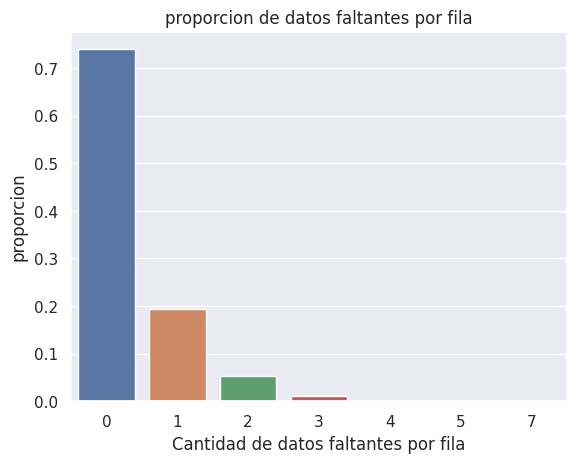

In [26]:
distribucion_faltantes_por_fila = (
    dataset_train.isna().sum(axis=1).value_counts() / dataset_train.shape[0]
)
ax = sns.barplot(
    x=distribucion_faltantes_por_fila.index,
    y=distribucion_faltantes_por_fila.values,
)
ax.set(
    xlabel="Cantidad de datos faltantes por fila",
    ylabel="proporcion",
    title="proporcion de datos faltantes por fila",
)


Vemos que la cantidad de filas con más de 3 datos faltantes es mínima.

## Imputación de datos faltantes

Algunas estrategias para imputar los datos faltantes son:

- Sustitución de Casos: Se reemplaza con valores no observados. Hay que consultar con un experto.
- Sustitución por Media: Se reemplaza utilizando la medida calculada de los valores presentes. Sin embargo, esto trae consecuencias
    - La varianza estimada por la nueva variable no es válida ya que es atenuada por los valores repetidos
    - Se distorsiona la distribución
    - Las correlaciones que se observen estaran deprimidas debido a la repetición de un solo valores constante.
- Imputación Cold Deck: Se pueden obtener los datos faltantes a partir de otras variables del dataset.
- Imputacion Hot Deck: Se reemplazan los datos faltante con los valores que resultan más “similares”. Tenemos que definir que es “similar”, para ello se puede usar la tecnica: K vecinos más cercanos.
- Imputación por Regresión: El dato faltante es reemplaza con el valor predicho por un modelo de regresión.
- MICE (multivariate imputation by chained equations): Trabaja bajo el supuesto de que el origen de los datos es MAR (missing at random). Es un proceso de imputación iterativo, donde cada iteración los valores faltantes se predicen en función de las variables restantes. El proceso se repite hasta que se encuentre consistencia en los datos (usualmente 10 iteraciones es suficiente). La primera iteración se realiza por uno de los métodos vistos anteriormente para rellenar los datos faltantes.

### Imputación de `property_bedrooms`, `property_rooms`, `property_price`

Anteriormente observamos que hay una correlación entre `property_bedrooms`, `property_rooms` y `property_price`. Podemos entrenar un modelo lineal para predecir los datos faltantes.

Imputamos los datos utilizando un imputador iterativo.

In [27]:
columnas_a_imputar = ["property_bedrooms", "property_rooms", "property_price"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    random_state=SEMILLA,
)

columnas_imputadas = imp.fit_transform(dataset_train[columnas_a_imputar])

dataset_imputado = pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(int)


Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 1.0, 'Distribución de precio de propiedad (imputado)'),
 Text(0.5, 0, 'precio de propiedad')]

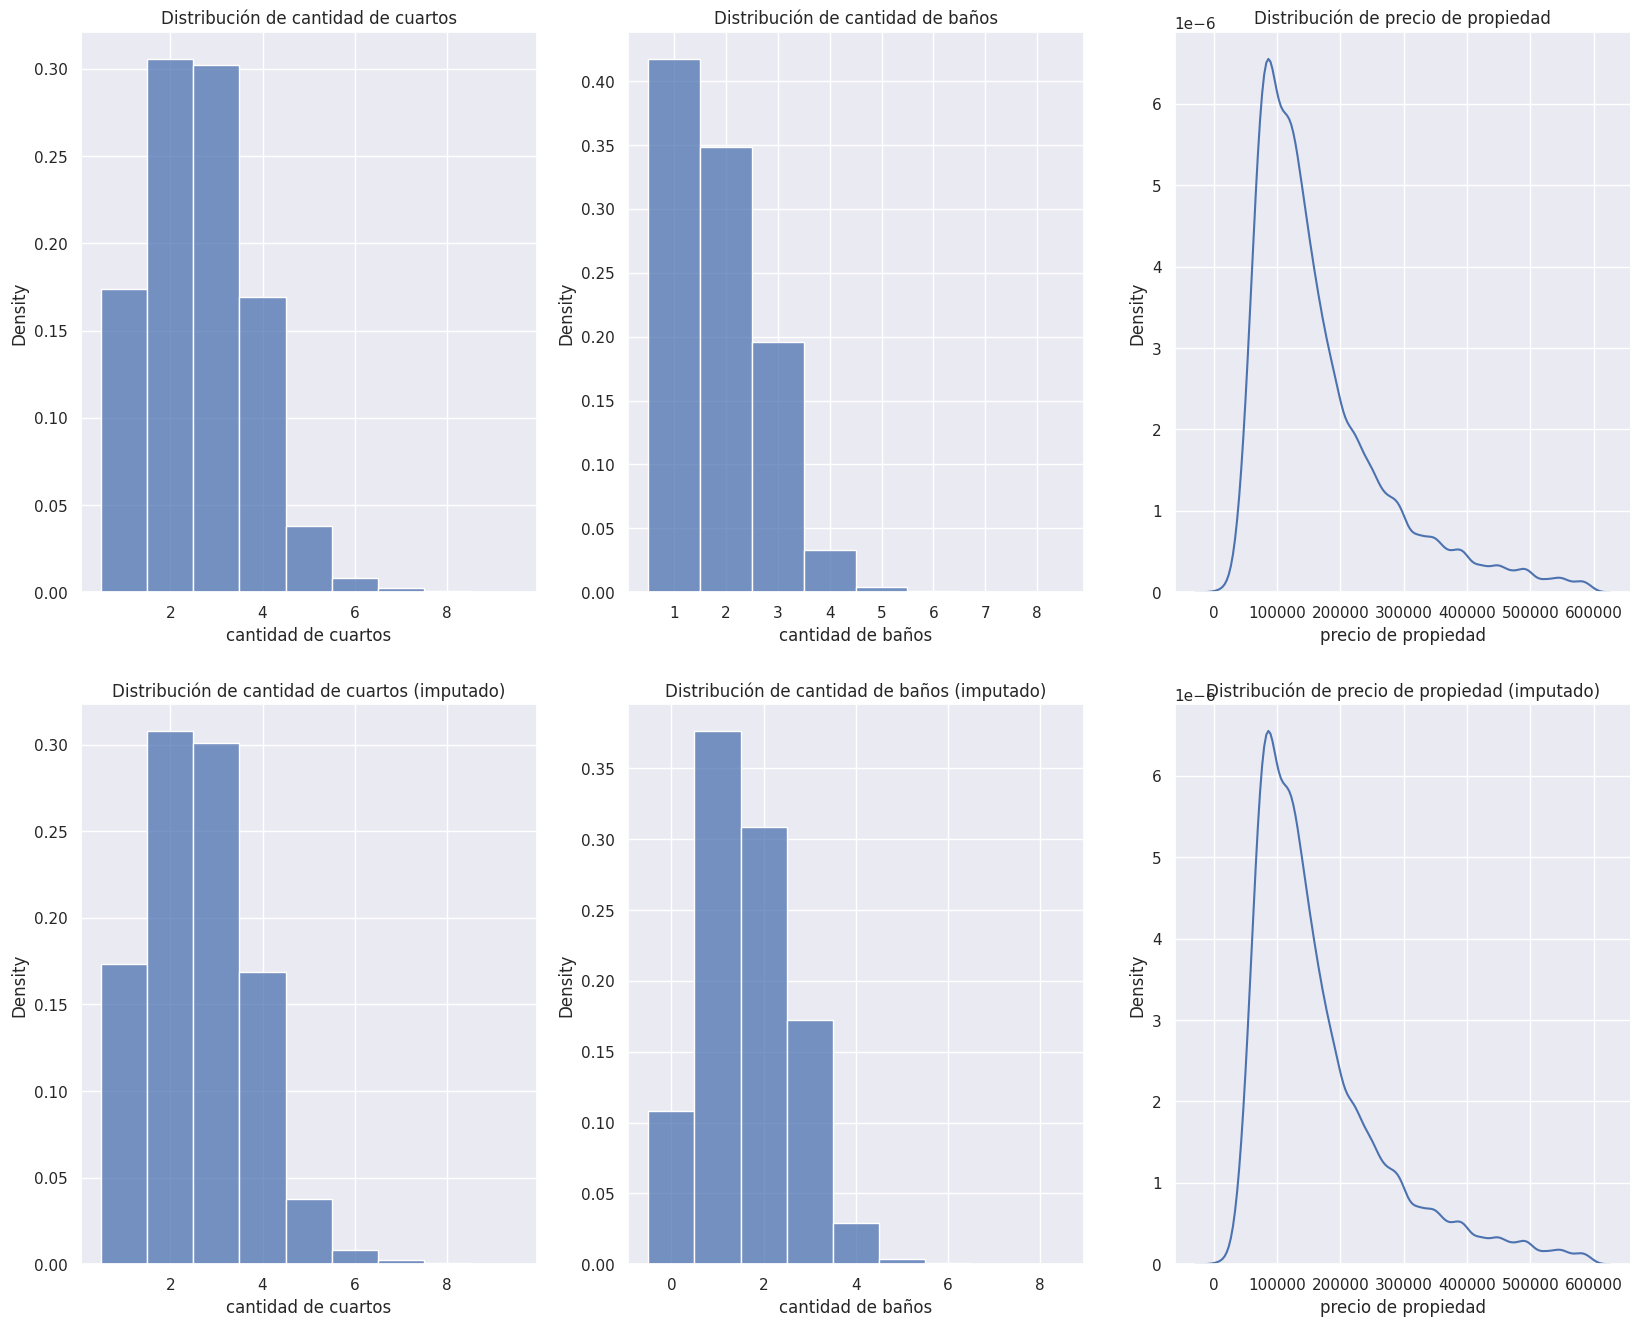

In [28]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de baños", xlabel="cantidad de baños")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="Distribución de precio de propiedad", xlabel="precio de propiedad")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_imputado.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos"
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_imputado.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de baños (imputado)", xlabel="cantidad de baños")

ax = sns.kdeplot(ax=axes[1][2], x=dataset_imputado.property_price)
ax.set(
    title="Distribución de precio de propiedad (imputado)", xlabel="precio de propiedad"
)


Actualizamos los valores imputados en el nuevo dataframe y vemos que las columnas imputadas ya no tienen valores faltantes.

In [29]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()

start_date                     0
end_date                    3637
created_on                     0
latitud                     2617
longitud                    2617
barrio                       155
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      3503
property_surface_covered    2431
property_price                 0
dtype: int64

### Imputación de `property_surface_covered`, `property_surface_total`


También habíamos observado una correlación entre `property_surface_covered`, `property_surface_total` por lo que podemos entrenar otro modelo lineal para predecir estos datos faltantes.

Imputamos los datos utilizando un imputador iterativo.

In [30]:
columnas_a_imputar = ["property_surface_covered", "property_surface_total"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    verbose=0,
    random_state=SEMILLA,
)

columnas_imputadas = imp.fit_transform(dataset_train[columnas_a_imputar])

dataset_imputado = pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(int)


Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 1.0, 'Distribución de superficie total (imputado)'),
 Text(0.5, 0, 'superficie total')]

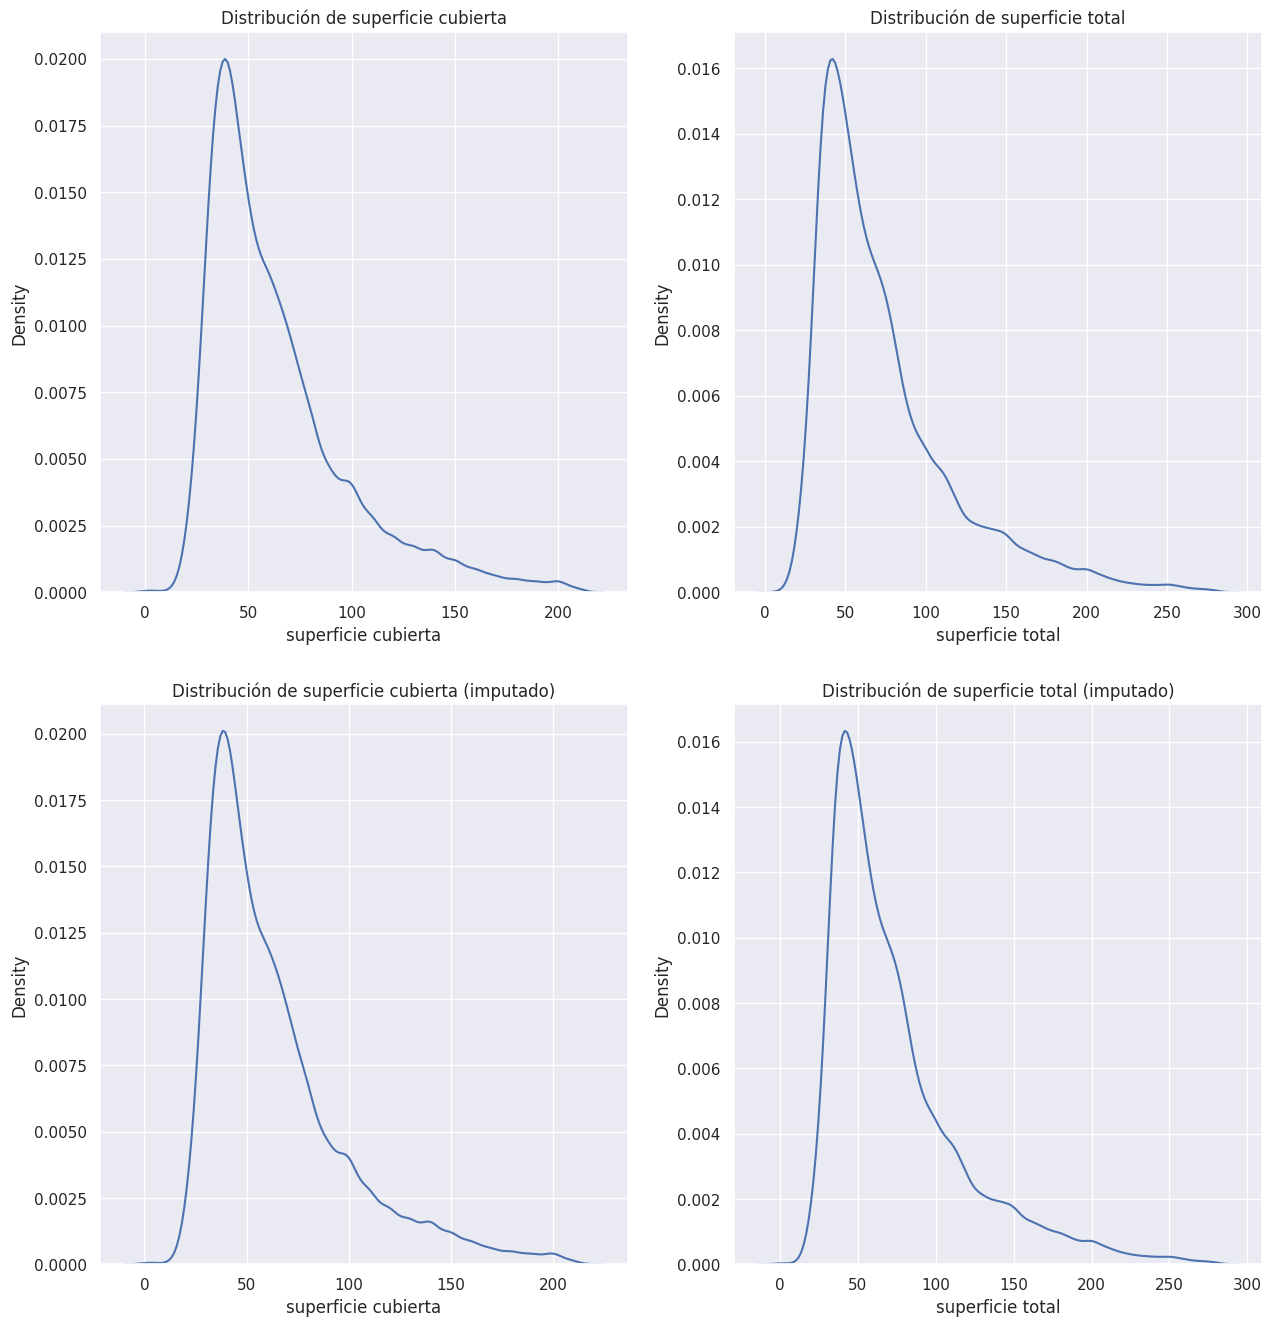

In [31]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="Distribución de superficie cubierta", xlabel="superficie cubierta")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="Distribución de superficie total", xlabel="superficie total")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_imputado.property_surface_covered)
ax.set(
    title="Distribución de superficie cubierta (imputado)", xlabel="superficie cubierta"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_imputado.property_surface_total)
ax.set(title="Distribución de superficie total (imputado)", xlabel="superficie total")


Actualizamos los valores imputados en el nuevo dataframe y observamos que ahora las columnas imputadas ya no tienen datos nulos

In [32]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


start_date                     0
end_date                    3637
created_on                     0
latitud                     2617
longitud                    2617
barrio                       155
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

Los datos faltantes de `end_date` no se van a quitar porque consideramos que representa que no se cerró el anuncio, y trabajaremos con esa información en mente.

### Imputacion `barrio` por `coordenadas`

Podemos entrenar un modelo que pueda predecir el barrio a partir de las coordenadas

In [33]:
dataset_forest = dataset_train.copy()
dataset_forest.dropna(inplace=True)

factorizacion_barrio = pd.factorize(dataset_forest["barrio"])
dataset_forest["barrio"] = factorizacion_barrio[0]
definiciones_barrio = factorizacion_barrio[1]

atributos = [
    "latitud",
    "longitud"
]

target = "barrio"

X = dataset_forest[atributos]
y = dataset_forest[target]

clasificador_rfc = DecisionTreeClassifier(
    random_state=SEMILLA,
)

Separamos en train y test, y escalamos los datos para mayor performance

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEMILLA)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Ahora, entrenamos el modelo y vemos su desempeño

In [35]:
clasificador_rfc.fit(X_train, y_train)

clasificador_rfc.score(X_test, y_test)

0.823848878394333

El desempeño es excelente, lo podemos utilizar para imputar los barrios faltantes. Sin embargo, solo lo podemos aplicar en filas que contengan coordenadas

In [36]:
def imputar_barrio(fila):
    if fila["barrio"] != None:
        return fila

    if fila[atributos].isna().any():
        return fila

    barrio = clasificador_rfc.predict([fila[atributos].copy()])

    fila["barrio"] = definiciones_barrio[barrio[0]]

    return fila

dataset_train = dataset_train.apply(imputar_barrio, axis=1)

Observamos la distribucion de faltantes hasta ahora

In [37]:
dataset_train.isna().sum()

start_date                     0
end_date                    3637
created_on                     0
latitud                     2617
longitud                    2617
barrio                       112
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `latitud`, `longitud` segun `barrio`

Primero, buscamos el punto medio de cada barrio. Para luego reemplazarlo en las coordenadas faltantes.

In [38]:
columnas_ubicacion = ["latitud", "longitud", "barrio"]
dataset_ubicaciones = dataset_train[columnas_ubicacion]
promedio_ubicaciones = dataset_ubicaciones.groupby("barrio").mean()


Ahora, podemos reemplazar los datos de latitud y longitud faltantes con el promedio para el barrio al que pertenecen

In [39]:
def imputar_cordenada(fila):
    barrio = fila["barrio"]

    if barrio == None:
        return fila

    fila["latitud"] = promedio_ubicaciones.at[barrio, "latitud"]
    fila["longitud"] = promedio_ubicaciones.at[barrio, "longitud"]

    return fila
    
dataset_train = dataset_train.apply(imputar_cordenada, axis=1)

Observamos la distribucion de datos faltantes

In [40]:
dataset_train.isna().sum()

start_date                     0
end_date                    3637
created_on                     0
latitud                      112
longitud                     112
barrio                       112
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Datos Faltantes Restanes

Finalmente, tenemos una cantidad muy baja de valores restantes en la ubicacion. Los podemos quitar para facilitar los analisis posteriores.

In [41]:
dataset_train = dataset_train[~dataset_train.barrio.isna()]

In [42]:
dataset_train.isna().sum()

start_date                     0
end_date                    3631
created_on                     0
latitud                        0
longitud                       0
barrio                         0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

## Análisis de Valores Atípicos Multivariados

Al intentar aplicar la medida de distancia Mahalanobis el algoritmo no funcionaba ya que multiplicar matrices de dimensiones tan altas requería de una cantidad de memoria RAM demasiado grande . Por otro lado, el algoritmo LOF tampoco funcionaba del todo bien ya que la información no está ordenada en clusters, por lo que los cálculos de densidad no daban bien. Debido a esto decidimos aplicar `IsolationForest` para analizar la presencia de valores atípicos multivariados.  

### Isolation Forest General

Para analizar los valores atípicos multivariados, vamos a utilizar el algoritmo `IsolationForest` con todas las variables numericas.

In [43]:

columnas = [
    "property_surface_total",
    "property_surface_covered",
    "property_rooms",
    "property_bedrooms",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()

iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=len(columnas),
    bootstrap=False,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(to_replace=[-1, 1], value=[True, False])

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
Cantidad de observaciones anómalas:
False    66021
True      3475
Name: outlier, dtype: int64


Realizamos un **pair plot** para analizar las correlaciones y cantidad de valores atípicos entre las variables.

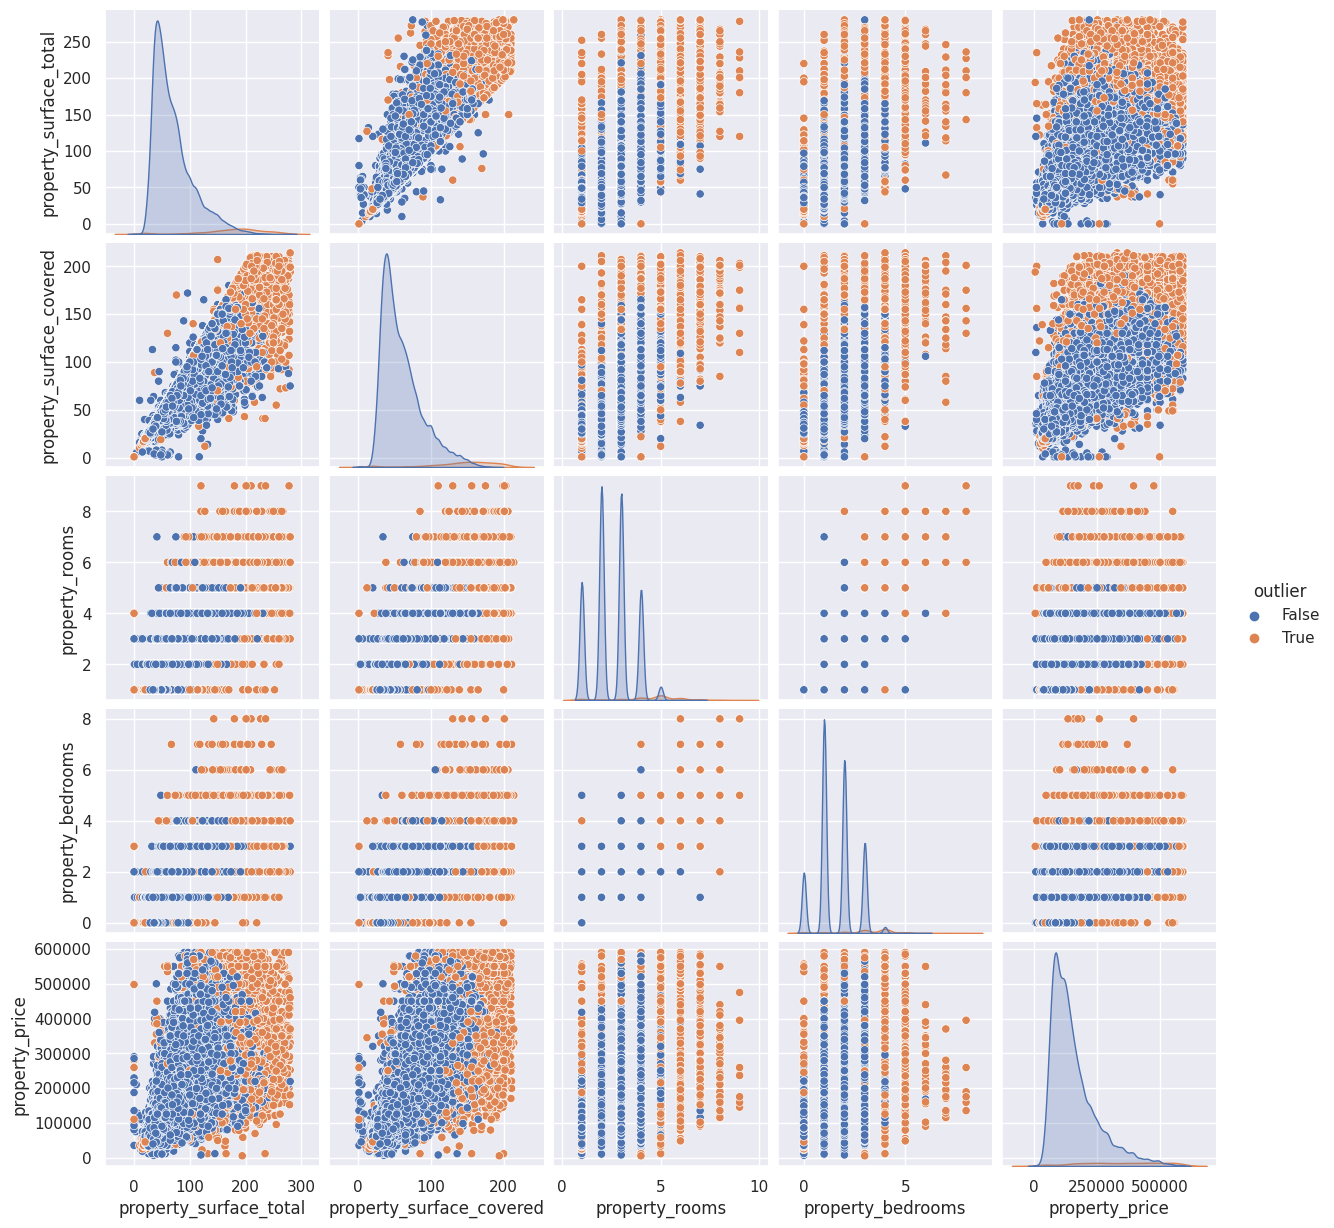

In [44]:
sns.pairplot(data=dataset_isolation_forest, hue="outlier")

Luego graficamos el árbol que se creó para la detección de outliers

In [45]:

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = iforest.estimators_[5]

export_graphviz(estimator,out_file='tree.dot',max_depth=5,
                feature_names = columnas,
                special_characters=True,rounded=True,precision=2)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')


Por último, quitamos las filas que son detectadas como outliers.

In [46]:

dataset_train = dataset_train[~dataset_isolation_forest.outlier]


### Isolation Forest para `property_surface_total` y `property_price`

Ahora vamos a analizar la distribución de valores atipicos en unicamente las columnas `property_surface_total` y `property_price`

Graficamos la distribución de esta variables en un **scatter plot**

<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

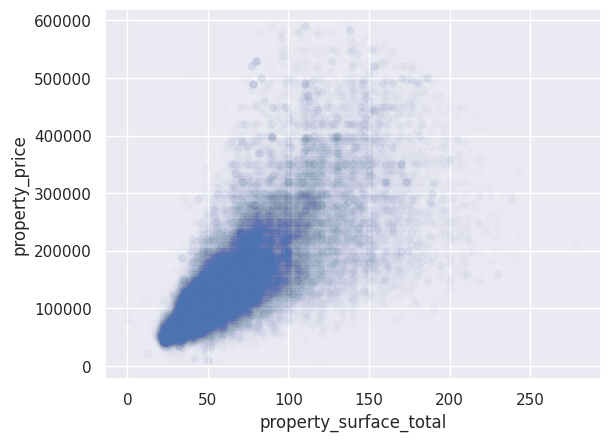

In [47]:
sns.scatterplot(data=dataset_train, x="property_surface_total", y="property_price", alpha=0.01)

Observamos que hay mucha concentración, con algunas observaciones dispersas. Realizamos otro `isolation forest` para identificarlas.

In [48]:
columnas = [
    "property_surface_total",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()

iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=len(columnas),
    bootstrap=False,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(to_replace=[-1, 1], value=[True, False])

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
Cantidad de observaciones anómalas:
False    62721
True      3300
Name: outlier, dtype: int64


Graficamos la distribución de outliers encontrada

<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

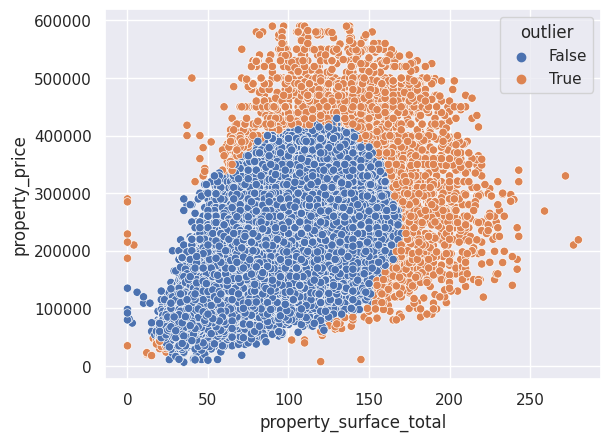

In [49]:
sns.scatterplot(data=dataset_isolation_forest, x="property_surface_total", y="property_price", hue="outlier")

Nuevamente, quitamos las filas clasificadas como outliers.

In [50]:
dataset_train = dataset_train[~dataset_isolation_forest.outlier]

Observamos la forma de nuestro dataset_train, luego del preprocesamiento

In [51]:
dataset_train.shape

(62721, 12)

## Reducción de Dimensionalidad

Para la reducción de la dimensionalidad usaremos el método de PCA ya que esta técnica permite hallar las combinaciones lineales de las variables originales que maximizan la varianza, es decir, minimizan la pérdida de información original.

Primero, transformamos el dataset en un dataset con variables numéricas, normalizamos los atributos y escalamos las variables.

In [61]:
dataset_pca = dataset_train.copy().dropna()

dataset_pca["start_date"] = pd.to_numeric(dataset_pca["start_date"])
dataset_pca["end_date"] = pd.to_numeric(dataset_pca["end_date"])
dataset_pca["created_on"] = pd.to_numeric(dataset_pca["created_on"])

dataset_pca = pd.get_dummies(dataset_pca, drop_first=True)

x = dataset_pca.values
x = StandardScaler().fit_transform(x)

Luego, le aplicamos el algoritmo de PCA.

In [62]:
from sklearn.decomposition import PCA

cantidad_componentes = len(dataset_pca.columns)

pca = PCA(n_components=cantidad_componentes) 
x_transformada = pca.fit_transform(x)

componentes_caracteristicos = [f"cp_{n}" for n in range(cantidad_componentes)]

dataset_pca_transformado = pd.DataFrame(data = x_transformada, columns = componentes_caracteristicos)

Analizamos la variabilidad explicada y la matriz de covarianzas que genera PCA.

In [63]:
varianza_explicada=pca.explained_variance_ratio_

varianza_explicada

array([6.32898691e-02, 3.96661826e-02, 3.50900890e-02, 3.29658483e-02,
       2.15039164e-02, 1.70815403e-02, 1.58758808e-02, 1.57292130e-02,
       1.56461094e-02, 1.54550943e-02, 1.54339639e-02, 1.52935391e-02,
       1.52653933e-02, 1.51666160e-02, 1.51207963e-02, 1.50618624e-02,
       1.50382110e-02, 1.50053133e-02, 1.49772702e-02, 1.49441099e-02,
       1.49358372e-02, 1.49281686e-02, 1.49111465e-02, 1.49059016e-02,
       1.48976986e-02, 1.48871627e-02, 1.48772275e-02, 1.48664701e-02,
       1.48538316e-02, 1.48451718e-02, 1.48272905e-02, 1.48202571e-02,
       1.48172738e-02, 1.48076887e-02, 1.48037141e-02, 1.47979547e-02,
       1.47955146e-02, 1.47905416e-02, 1.47845811e-02, 1.47806772e-02,
       1.47763721e-02, 1.47742815e-02, 1.47722218e-02, 1.47679735e-02,
       1.47521991e-02, 1.47483359e-02, 1.47427656e-02, 1.47381552e-02,
       1.47320941e-02, 1.47272926e-02, 1.47237385e-02, 1.47209471e-02,
       1.47141475e-02, 1.47104983e-02, 1.47073713e-02, 1.47042934e-02,
      

In [64]:
pca.get_covariance()

array([[ 1.00001682,  0.76332579,  1.00001682, ...,  0.01396137,
         0.00645716, -0.0037273 ],
       [ 0.76332579,  1.00001682,  0.76332579, ...,  0.00747149,
         0.01109264, -0.01037452],
       [ 1.00001682,  0.76332579,  1.00001682, ...,  0.01396137,
         0.00645716, -0.0037273 ],
       ...,
       [ 0.01396137,  0.00747149,  0.01396137, ...,  1.00001682,
        -0.04251982,  0.03772006],
       [ 0.00645716,  0.01109264,  0.00645716, ..., -0.04251982,
         1.00001682, -0.94982557],
       [-0.0037273 , -0.01037452, -0.0037273 , ...,  0.03772006,
        -0.94982557,  1.00001682]])

Graficamos la varianza explicada en relación a la cantidad de componentes principales en un **scree plot**.

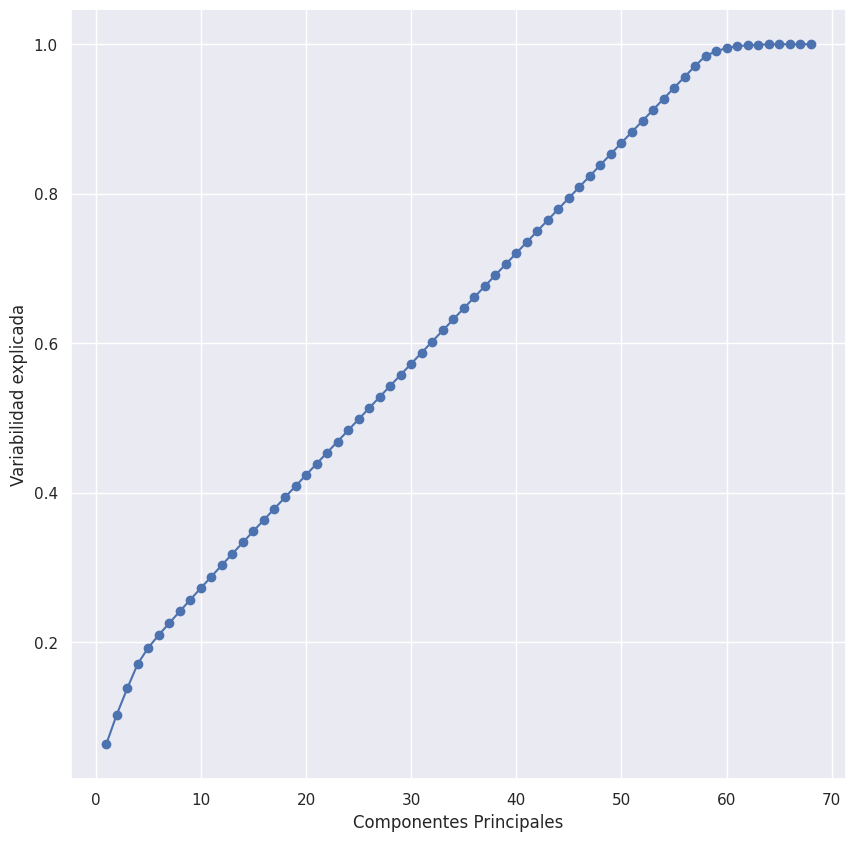

In [65]:

list_x = list(range(1, len(varianza_explicada)+1))

# Gráfico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(10, 10))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

In [66]:
n_componentes_elegido = 55
print(f"La varianza explicada tomando {n_componentes_elegido} componentes principales es {varianza_explicada[:n_componentes_elegido].sum()}")

La varianza explicada tomando 55 componentes principales es 0.9416533223983834


Por lo tanto, concluimos que nos podemos quedar con 55 componentes principales, sin perder mucha variabilidad en los datos.

In [68]:
dataset_pca_transformado = dataset_pca_transformado.iloc[: , :n_componentes_elegido]
dataset_pca_transformado

cp_0      cp_1      cp_2      cp_3      cp_4      cp_5      cp_6  \
0     -0.322701 -2.525899 -1.195228 -1.783341  0.140389 -1.053832 -1.355324   
1      0.255912  0.530039 -0.671758  2.254448 -0.857026 -0.860894 -0.215156   
2      0.063005 -2.461113 -1.361672 -0.332701 -0.597474  2.395810 -0.490809   
3      2.152492  0.959632 -1.571859  1.238993 -0.178078 -0.739599 -0.024805   
4     -2.699139  2.384234 -0.658144 -0.516354 -0.915809  2.400580 -0.521217   
...         ...       ...       ...       ...       ...       ...       ...   
59443  4.442609 -1.286482 -2.455122 -2.290052  0.059773 -0.777768  0.838206   
59444  0.105422 -0.455789  0.241399  1.025593  1.790085  0.208137  1.763969   
59445  0.720464 -3.125438 -0.155216 -1.964540  0.935994 -0.491631  1.023037   
59446  2.364148 -1.191998 -0.386379  1.161065  2.014721  0.273202  1.758054   
59447 -0.607920  0.544924 -0.387790  0.479258 -0.039943  0.064028  0.074813   

           cp_7      cp_8      cp_9  ...     cp_45     cp_46     cp_47  \
0      2.008594  1.400451 -0.195789  ... -0.029720  0.046317 -0.064619   
1      0.308936 -0.255310 -0.692554  ...  0.043363 -0.042747  0.118162   
2     -0.069122 -0.202197 -0.007556  ... -0.003008  0.003932  0.004021   
3     -0.582792 -0.616521 -0.626767  ... -0.036416  0.068077 -0.116784   
4     -0.023521 -0.161391 -0.060174  ... -0.012166  0.005145 -0.016041   
...         ...       ...       ...  ...       ...       ...       ...   
59443 -0.946431 -1.983520  1.283177  ... -0.042320  0.035966  0.034215   
59444  1.749411 -1.337431  0.003096  ...  0.016323  0.017915 -0.027330   
59445 -1.441399  0.365150 -2.029248  ... -0.002022  0.001772  0.052811   
59446  1.701108 -1.381252  0.019521  ...  0.023736  0.011736 -0.006494   
59447  0.016050  0.093051  0.002246  ... -0.003546 -0.003118 -0.002937   

          cp_48     cp_49     cp_50     cp_51     cp_52     cp_53     cp_54  
0      0.074024  0.007254 -0.020288  0.021902 -0.000173 -0.011964 -0.015802  
1     -0.214047  0.123246 -0.004484 -0.223137  0.032321  0.022260 -0.020164  
2      0.005996  0.004236 -0.008071 -0.005076  0.003374  0.000888 -0.002456  
3      0.095947  0.061775 -0.019286  0.005304 -0.001718 -0.021620 -0.026100  
4      0.008512  0.015585 -0.001762 -0.001462 -0.000526 -0.007870 -0.001371  
...         ...       ...       ...       ...       ...       ...       ...  
59443  0.028064  0.020854 -0.025571 -0.027288  0.035452 -0.008869 -0.006267  
59444  0.023482  0.019979 -0.018987  0.015718 -0.031750 -0.005382 -0.005215  
59445  0.009002  0.006747 -0.014111 -0.015445  0.016837  0.001216  0.003524  
59446  0.010663  0.019714 -0.018244  0.008544 -0.029134 -0.001840 -0.002783  
59447  0.001657  0.000319  0.000954 -0.000433  0.001162 -0.000956  0.000401  

[59448 rows x 55 columns]

# 2. Agrupamiento

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc9b46f5-899c-4314-8e44-8f9e77759939' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>